In [1]:
import scipy.stats as stats
import pymc3 as pm
import numpy as np

# Signal-only model

In [2]:
# Generate the signal data
mean = 50.0
sigma = 5.0
data = stats.norm.rvs(loc=mean, scale=sigma, size=1000)

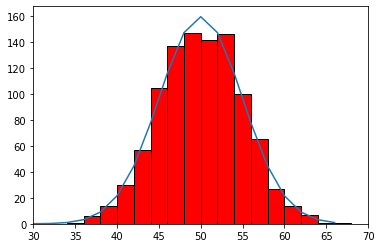

(19,)


In [109]:
# Plot data as histogram, and model on it

def MyModel(x, A, mu, sigma):
    #y = A*stats.norm.pdf(x, loc=mu, scale=sigma)
    y = A*np.exp(-0.5*(x-mu)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma) 
    return y

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
binwidth = 2
bins = np.arange(30, 70, binwidth)
hist, edges = np.histogram(data, bins)
#ax.hist(data, density=False, histtype='stepfilled', alpha=0.2)
plt.bar(bins[:-1], hist, width=binwidth, align="edge", ec="k", color='red')
plt.plot(bins[:-1], MyModel(bins[:-1],2000, mean, sigma))
ax.set_xlim(30, 70)
plt.show()
print(bins[:-1].shape)

In [125]:
# Assume Poisson Likelihood, and Gaussian priors
with pm.Model() as model_sig:
    # Prior on the mean
    m = pm.Uniform("m", lower=1,upper= 1000)
    Amp = pm.Uniform("A", lower=1, upper = 10000)
    s = pm.Uniform("s", lower=1, upper=100)
    # Likelihood Poisson
    y = pm.Poisson("y", mu=MyModel(bins[:-1]+binwidth/2,Amp, m, s), observed = hist)
    # instantiate sampler (optional)
    step = pm.Metropolis() 
    # Draw posterior samples
    trace = pm.sample(20000, step=step, tune=2000,cores=2)  # Explore and Sample the Parameter Space!


/var/folders/24/yt0nmmbs2rg59yttm9w266w80000gn/T/ipykernel_34562/793199031.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(20000, step=step, tune=2000,cores=2)  # Explore and Sample the Parameter Space!
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [A]
>Metropolis: [m]


/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 2_000 tune and 20_000 draw iterations (4_000 + 40_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


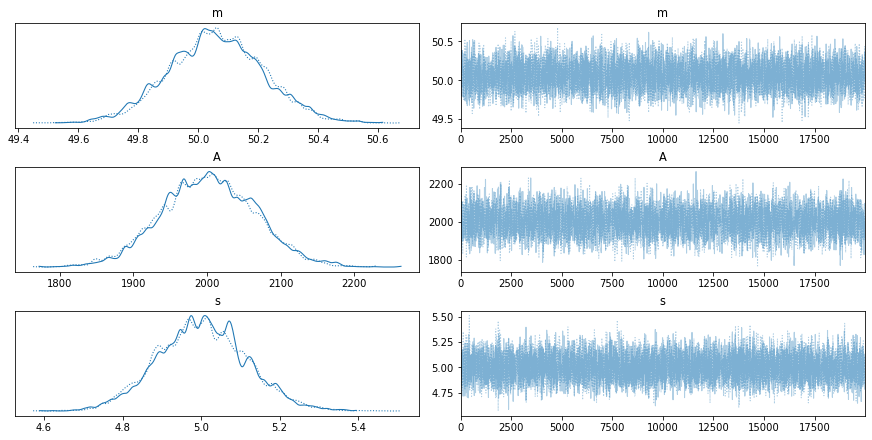

In [126]:
# Exploratory analysis of bayesian models with python
import arviz as az

az.plot_trace(trace);

In [2]:
# Plot autocorrelations
#pm.plot_autocorr(trace, combined=True);
pm.plots.autocorrplot(trace,figsize=(17,5), combined=True);

NameError: name 'pm' is not defined

/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'m'}>,
       <AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'s'}>], dtype=object)

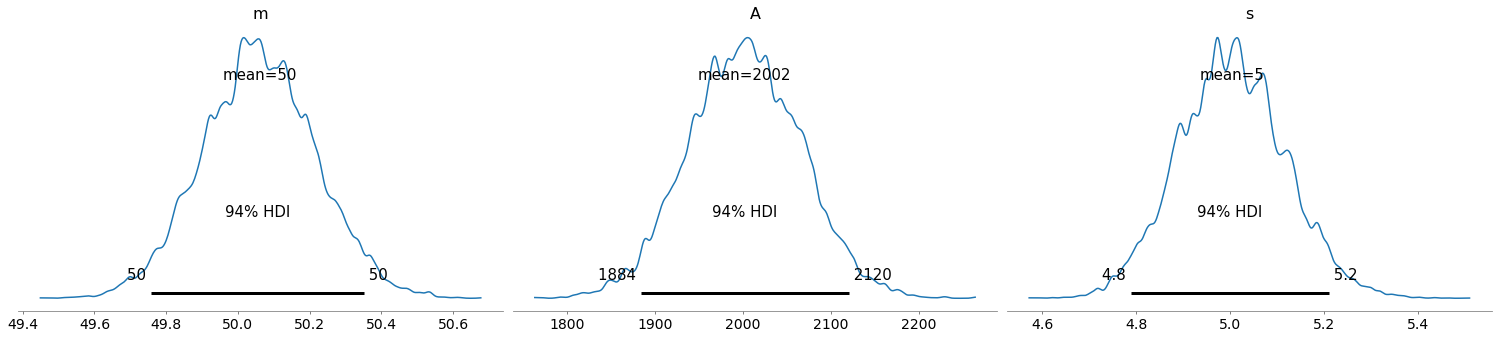

In [128]:
pm.plot_posterior(trace)

/var/folders/24/yt0nmmbs2rg59yttm9w266w80000gn/T/ipykernel_34562/2962968322.py:1: DeprecationWarning: The function `pairplot` from PyMC3 is just an alias for `plot_pair` from ArviZ. Please switch to `pymc3.plot_pair` or `arviz.plot_pair`.
  pm.pairplot(trace, kind='kde');
/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


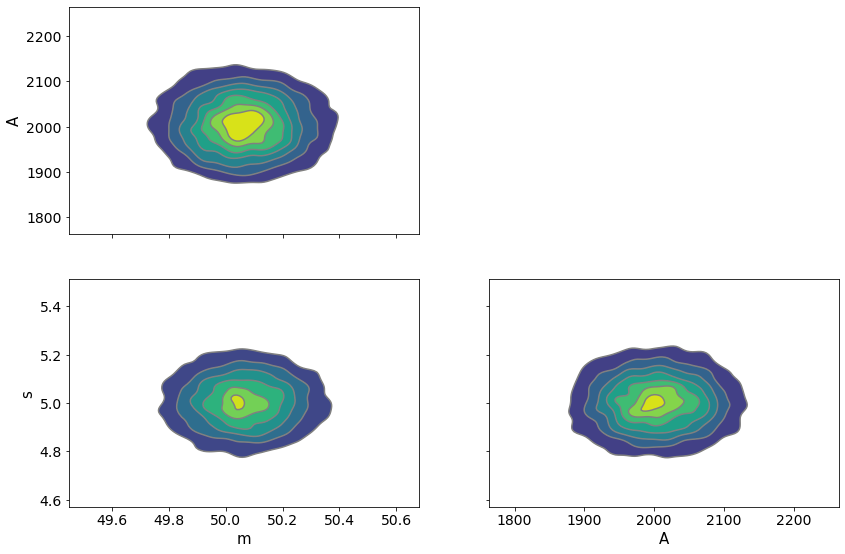

In [129]:
pm.pairplot(trace, kind='kde');

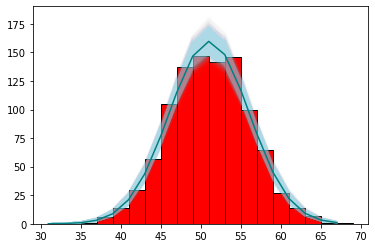

In [140]:
# Visualize uncertainty

# plot the data
plt.bar(bins[:-1]+binwidth/2, hist, width=binwidth, align="edge", ec="k", color='red')

# Get the mean inferred values
A_m = trace["A"].mean()
m_m = trace["m"].mean()
s_m = trace["s"].mean()

# Plot all draws
draws = range(0, len(trace["A"]), 10)
plt.plot(bins[:-1]+binwidth/2, MyModel(bins[:-1, np.newaxis],trace["A"][draws], trace["m"][draws], trace["s"][draws]), c='lightblue', alpha=0.01)

# Plot the mean regression line
plt.plot(bins[:-1]+binwidth/2, MyModel(bins[:-1], A_m, m_m, s_m), c='teal')

ax.set_xlim(30, 70)
plt.show()



/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


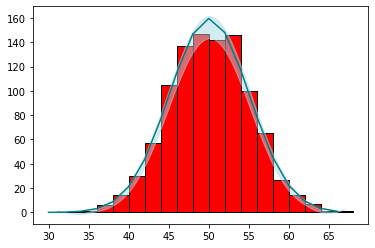

In [133]:
# Plot posterior predictive values for each bin

# plot the data
plt.bar(bins[:-1], hist, width=binwidth, align="edge", ec="k", color='red')

ppc = pm.sample_posterior_predictive(trace,
                                     samples=2000,
                                     model=model_sig)

# Plot the posterior predicted samples, i.e. these are samples of predicted y for each original x in our data
az.plot_hdi(bins[:-1]+binwidth/2, ppc['y'], hdi_prob=0.5, color='lightblue')


# Plot the mean regression line - from cell above
plt.plot(bins[:-1], MyModel(bins[:-1], A_m, m_m, s_m), c='teal')



In [134]:
# What is the acceptance rate?
accept = np.sum(trace['m'][1:] != trace['m'][:-1])
print("Acceptance Rate for par m: ", accept/trace['m'].shape[0])

Acceptance Rate for par m:  0.224525


In [ ]:
# Convergence


In [135]:
pm.summary(trace)

/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,50.060,0.158,49.757,50.351,0.002,0.001,6222.0,6363.0,1.0
A,2001.879,63.856,1884.095,2120.483,0.882,0.624,5251.0,5974.0,1.0
s,5.003,0.113,4.788,5.211,0.001,0.001,6664.0,6889.0,1.0
